In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/design_and_analysis/code_in_progress')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness)



# How to run an efficiency analysis

This notebook outlines the steps you should take to run an efficiency analysis.  If this is done carefully, you'll likely pick up on a few things about the design that can be improved, aside from efficiency and psychological fitness of trial ordering.  When you run your first one I highly recommend taking your time and really thinking things through.  Think about the different measures we're using to choose a design and how flexible you can be with your task design.  The first one will take a while, but the future calculations will go a lot faster.

This example is for the stop signal task.  In this case we won't *exactly* be setting up our future design matrix since correct trials and the timing for the go signal are dependent upon the subject performance.  Instead we focus on a generic stop-go contrast as the main contrast of interest as well as optimizing the stop vs baseline and go vs baseline contrasts.  That's okay!  We do what we can!  The basic steps are:

1.  Put some deep thoughts into the specific details about your task.  This is when you should sketch out a diagram of what the timings will look like and you can even consider a couple of options you'd like to compare.  
2. Think about the ISIs.  Generate a distribution for the settings you're planning on using for your ISIs (Inter Stimulus Interval) and make sure the range of values is okay and that you're okay with how many longer ISIs might occur (I use a truncated exponential that is then shifted below).
3. Write code for generating your event timings (what is needed to make a design matrix).  This takes the most time and will likely need to be created differently for each task.  
4. Run some preliminary analyses (play!).  Generate 500 or so designs for each design setting you're considering and study the metrics.  At this point I take a peek at the psychological assessment measures once, but primarily focus on the measures that assess the within-subject variance and other things that are impacted by the number of trials I'm choosing and ISI settings.  These values would be efficiency, VIF, and duration of the scan.
5. Make your final design setting decision and run a ton of design generations on Sherlock and use *all* of the measures to select a handful of best ones, balancing the statistical measures with the psychological measures.

### Review items
I figured it would be good to review some terminology
* Efficiency:  This is related to the inverse of the within-subject variance estimate.  In reality the variance estimate for a contrast, $c$ is $c(X'X)^{-1}c'\hat\sigma^2$, where $\hat\sigma^2$ is the residual variance estimate and $X$ is the design matrix.  We won't have that until we have a design matrix, so efficiency is $1/c(X'X)^{-1}c'$, so if we double efficiency we cut the within-subject variance in half!
    * Things that increase efficiency include:  Having as many trials as possible, avoiding overlap in the signal from different events (not spacing events out) and blocking trials.  Remember the Russ detection example from before?  It is much easier to detect the Russ signal when there's a block of Russ's.  Same goes for events in that if there are 20 go trials in a row they are easier to detect than 20 go trials spaced out with a lot of stop trials in between (of course the former is not necessarily good from the psychological perspective).
    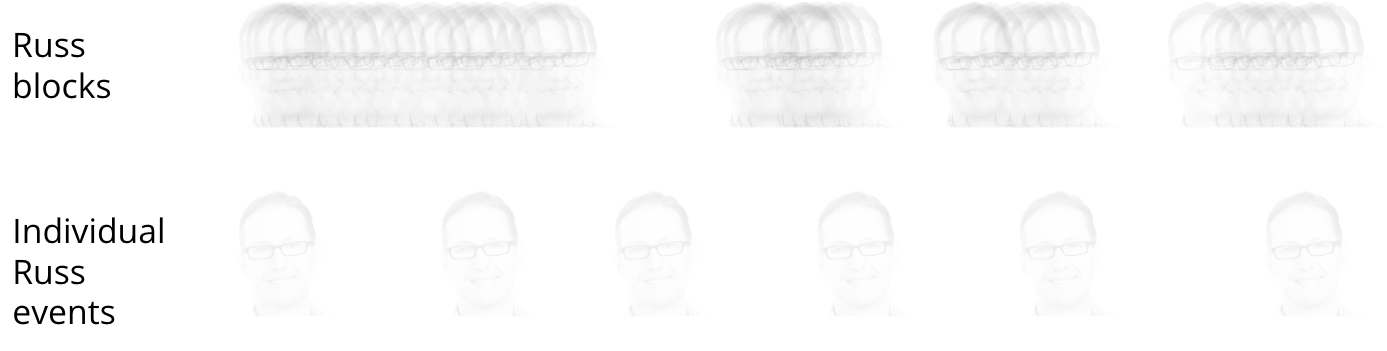
* Variance Inflation Factor (VIF): This is mistaken as a surrogate for efficiency, but it isn't.  It is a measure of the collinearity of your model (you can have design with equal VIF's but very different efficiencies).  It can be a bit tricky.  If you're looking at the VIF for a contrast, check that the parameters going into the contrast have good VIFs (<5).  If they do not, then further investigation is necessary to determine whether the VIF for the contrast is okay to interpret.  First question is whether the high VIF for individual conditions vs baseline is driven by other conditions in the contrast.  For example, we'll see below that for the stop-go contrast go vs baseline tends to have a higher VIF, so the question is whether or not we believe the low VIF for stop-go.  To dig deeper we check if stop is involved in the increased VIF for go and find that it is.  With a little more digging we realize that this is only occurring because there's so little baseline in the task.  This one is harder to puzzle out, but I'll explain it like this:  If we know a stop trial is not occurring at a single point in time, can we make a pretty good guess about whether or not a go trial is happening?  Think of baseline as another stimulus.  Since there's hardly any baseline, if the stop trial isn't happening, if we were to guess a go trial was happening (instead of baseline) we'd likely be correct!  If we had a lot more baseline then our guess that go is happening when stop isn't happening will not be as accurate because baseline becomes more likely.  So, in a nutshell, in this case even though stop is driving the high VIF for go (I'll show how I figured this out below), since it is only occurring because there is so little baseline in the task, we *can* believe the VIF for stop-go, although we also know that if we'd like to study condition vs baseline contrasts specifically we'll want to add more baseline.  Hopefully that makes sense! I walk through this below.
* Psychological assessments:  We went over about 6 measures for assessing the psychological fitness of a design.  This only involves the trial order and is not impacted by ISIs or run length, so not much time is spent on it in this notebook, but it is really important for selecting the final specific designs that will be used, whereas here we're mostly focused on nailing down the general settings for generating designs. Here's a quick review about each measure.  Note lower is better for all of these measures.
    * Kao Measure: This is from the Kao paper and is based on the expected number of times two matching stimuli are adjacent, 1 trial apart and 2 trials apart.  The measure is the sum of the absolute difference of the observed values and the expected values.  It is okay, but may lead to designs with more repeats of the same condition than we'd expect by chance.  (Runs of the same condition occuring in a row).
    * Probability a run is longer than 2 trials: This was created to adjust for the issue of the last measure.  If you're performing the task and the current trial is different from the last, what's the probability that the next trial matches the current one?  That's what this estimates (probability that a run is equal to or larger than 2 trials).
    * Probability of the next trial given the last trial:  Just what it sounds like.  For each pair of conditions (e.g. A and B) it calculates the probability that the next trial will be B if the current trial is A.  It calculates this for all pairs of trials and the statistic is the maximum of these values.
    * Probability of the next trial given the last 2 trials:  Same as above, but for all triplets, A, B, C, calculates the probability that the next trial is C given that last trial was B and the trial before that was A.  Calculates this for all triplets of trials and the max is the statistic that is used.
    * Prediction of second half from the first half: Calculates the probability of the next trial given the last using the first half of the scan and attempt to predict each trial type for the second half.

Buckle up.  Here we go.

### Step 1:  Figure out your task details

For this step you really need to think through every little bit of the task.  In this case, since Team Patrick $^\copyright$ are collecting so many tasks in a single session, the choice has been made to continue scanning between "runs" of a single task, allowing the subject to take a mini break.  This is a bit faster than stopping the acquisition and restarting it (note, in more normal circumstances I'd recommend stopping acquisition and restarting).  To avoid confusion I'll refer to these as blocks of the task within a single scanning run.  After some discussion, this is a rough plan of the design for a single run, with an exception that Team Patrick $^\copyright$ wants the Break trials to be 10s long and I've made them 16s because I wanted to start with more fixation before/after to allow separation of the break signal with the task signal.  Essentially I like to start with a design that I think will be good and then dial things in from there. I've "penciled" in some timing values that might change (like the random ISI and fixed fixation lengths).  I also sampled the ISI distribution I'm going to start with and showed to it Team Patrick $^\copyright$ to make sure it was what they expected.  Code for creating the ISI distribution will be given below.

There will be 3 blocks, each block will have 20 stop trials and 40 go trials and the goal is for the entire run to be under 9 minutes.  Here's my sketch of the task and I highly recommend you do this and save it somewhere where it will be easy and obvious to find in 5 years.  Make sure the saved version is based off of whatever settings you ended up using.  It is the quickest way to communicate your task with others.  If you write a data descriptor paper in the future this will make your life much,  much easier, since you'll want to explain how you designed your task.

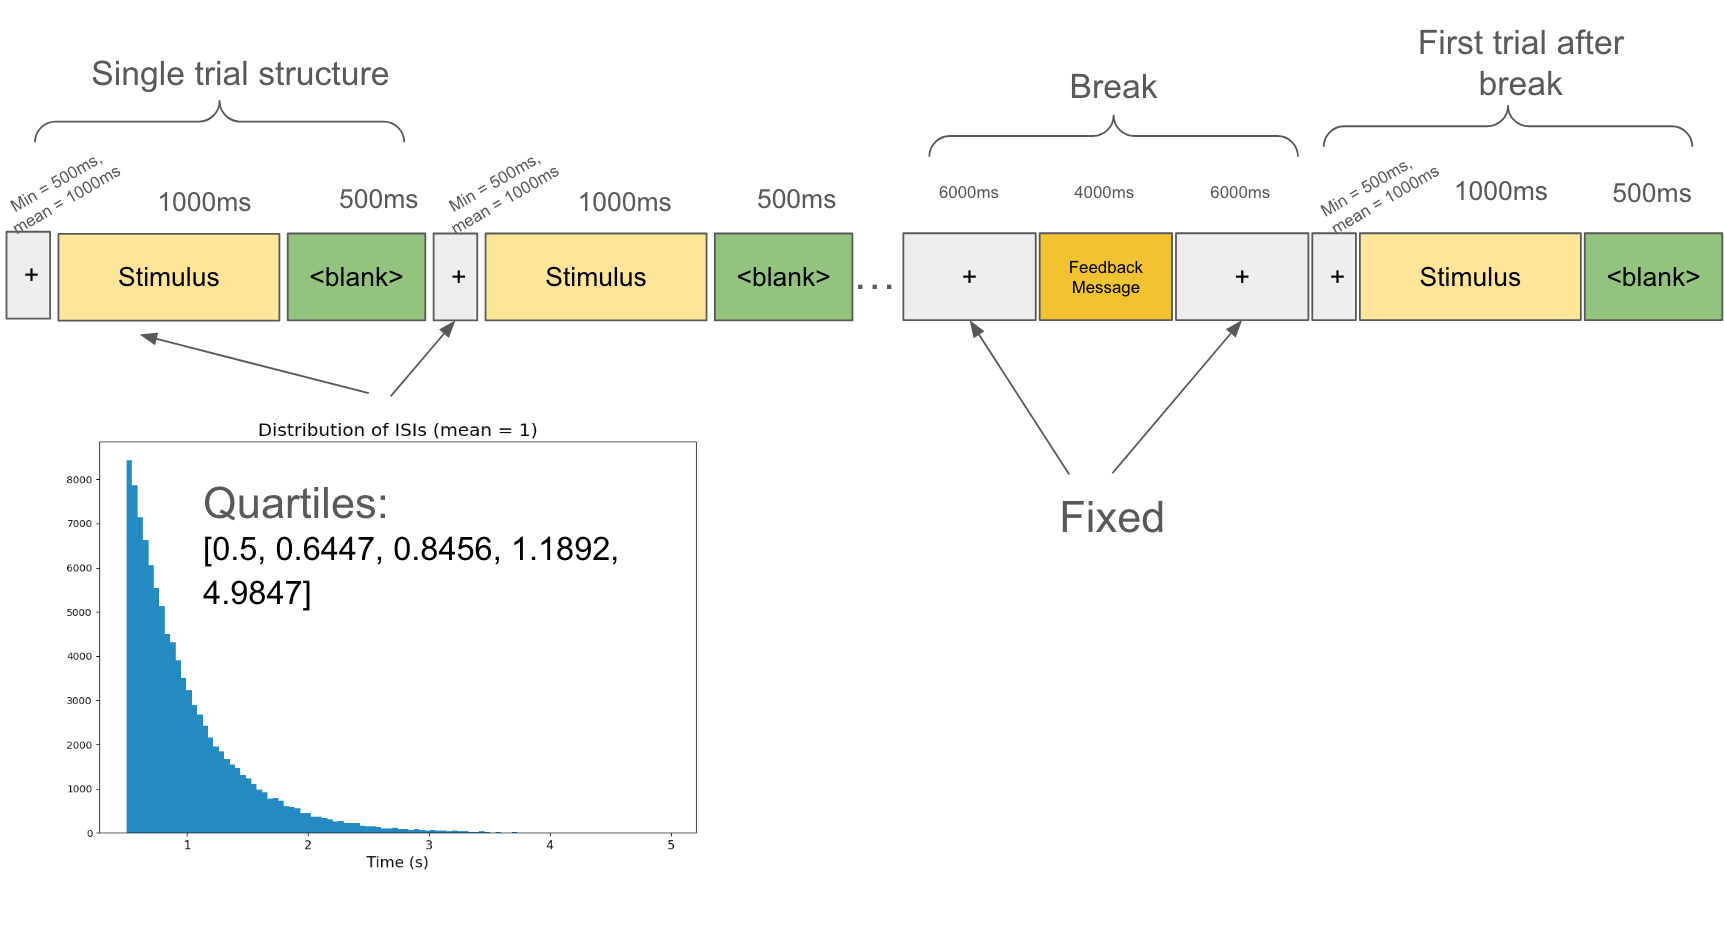


### Step 2:  Assess the distribution of ISIs you're starting with

I chose what I think is a good starting point, but will consider shorter and longer ISIs.  For the purposes of efficiency, we need to keep the run length the same for all designs, so it is okay to go a little above what you're hoping for to keep this consistency.  Note, that for VIF you'll want to trim the "dead time" at the end of the scan off if there is any (this is done for you when my code estimates VIF).  

I'm using a truncated exponential and note that the truncation value is applied *prior* to the shift of the distribution, so the min fixation is the shift value and the max is the truncation value plus the shift.  The inverse of lambda plus the shift is roughly the mean, but the code also spits out the theoretical mean, which is what should be reported.  If you use a really low truncation value, the true mean will lower than the inverse shift + lambda (the mean without truncation).

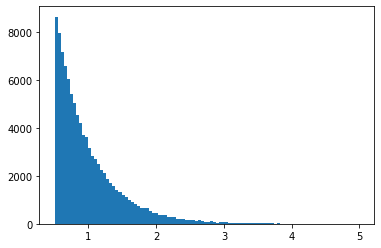

The theoretical mean is: 0.9994445873382422
Quartiles: [0.5   0.643 0.846 1.194 4.992]


In [2]:
isi_exp_lam = 2
isi_truncation = 4.5
isi_shift = .5
nsamp = 100000 # so we get a nice histogram of the distribution
samples, theoretical_mean = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                                 isi_shift, nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.show()
print(f'The theoretical mean is: {theoretical_mean}')
print(f'Quartiles: {isi_quartiles}')

### Step 3: Write code to generate random events files

Now you're ready to randomly generate trial orderings and ISI timings.  This code is a bit more involved than usual because of the 3 blocks.  I will be randomly permuting the trial order, but I want to keep the number of stop/go trials exactly the same within each block.  This should be pretty clear from the code.

Note I start by making a vector that has the timings of each 'fragment' or piece of the trial (every rectangle in the above diagram of the task).  I then use the cumulative sum function to sum these values to get the onset times of each of the fragments.  I only want stop/go/feeback message, so I extract those onsets to generate the BIDS-style events data frame.

Be extra careful when generating these onsets.  It is easy to make mistakes, especially during the subset bit.  If you have a work buddy who can double-check your code, ask if they'll take a look.  Also, let me know if you think you see an error in my code!

In [3]:
def make_stop_signal_timings(nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Produces a randomly ordered set of trials for the stop signal task.
    Assumes a break between blocks of task.  Number of stop/go trials will be equal
    for each block of the task (nstop/(nbreaks + 1))
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A trial is structured as:
      fixation (based on truncated exponential) + 
      either a stop/go trial (duration = stop_dur/go_dur) +
      blank screen (duration = blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      nstop: Total number of stop trials (will be evenly split between blocks)
             Integer divisible by (nbreaks + 1)
      ngo: Total number of go trials (will be evenly split between blocks)
           Integer divisible by (nbreaks + 1)
      stop_dur: Duration of a stop trial
      go_dur: Duration of a go trial
      blank_dur:  Duration of blank screen after stop/go stimulus offset
      nbreaks: Total number of breaks (blocks = nbreaks + 1)
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
       Includes stop/go/break message timings
    '''
    nblocks = nbreaks + 1
    ntrials = nstop + ngo
    ntrials_per_block = int(ntrials/nblocks)
    nstop_per_block = int(nstop / (nblocks))
    ngo_per_block = int(ngo / (nblocks))
    isi_vals, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                                    isi_shift, ntrials)

    # fragments = all sub-components of the run (go/stop/fixation/blank/break_message)
    # Each stimulus has 3 fragments and each break has 3 fragments
    isi_count = 0
    fragment_durations = []
    fragment_labels = []
    for cur_block in range(nblocks):
        stim_type_block = np.random.permutation(np.concatenate((np.repeat(['stop'], nstop_per_block),
                                                        np.repeat(['go'], ngo_per_block))))
        for cur_trial in range(ntrials_per_block):
            cur_stim_type = stim_type_block[cur_trial]
            stim_dur_cur_trial = stop_dur if cur_stim_type == 'stop' else go_dur
            fragment_durations.extend([isi_vals[isi_count], stim_dur_cur_trial, blank_dur])
            fragment_labels.extend(['isi_fix', cur_stim_type, 'blank'])
            isi_count = isi_count + 1
        #Add break
        fragment_durations.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels.extend(['fix_break', 'break_message', 'fix_break'])

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[(events_data.trial_type == 'stop') |
                    (events_data.trial_type == 'go') |
                    (events_data.trial_type == 'break_message')]
    return events_data

### Step 4: Play time!

Time to tinker!  I'll start with my original guess and then try out some different things.  For this design I already knew some options were not really on the table, but I ran them here for illustrative purposes.  For example, I know we cannot really go up to 10 minutes, but I allowed the scan to be 10 minutes long so I could try longer ISIs, etc.

500 simulated designs should be adequate for this play time.

In [4]:
nstop = 60
ngo = 120
stop_dur = 1
go_dur = 1
blank_dur = .5
nbreaks = 2
break_fix_pre_message_dur = 6
break_message_dur = 4
break_fix_post_message_dur = 6
isi_exp_lam = 2
isi_truncation = 4.5
isi_shift = .5

tr = 1.49
total_time = 10*60
contrasts = {'stop': 'stop',
             'go': 'go',
             'stop-go': 'stop - go',
             'task': '.5*stop+.5*go'}


We need the expected number of trial repeats (also called 'runs' of trials in the source code, sorry for any confusion).  This code just randomly permutes the trial orders a bunch of times and counts how many runs occur for each run length and each condition (e.g. how many times two go trials occur in a row).  

Since we have 3 blocks of trials and are only permuting within each block, I enter 1/3 of the total number of trials into ``calc_expected_run_num_by_chance`` and then I triple the resulting run counts that are estimated.

This will be used when assessing the psychological fitness.  Do not put this code in a loop, since it takes a while to run and will really slow things down.

In [5]:
unpermuted_trials = np.concatenate([np.repeat('s', nstop/3), 
                                    np.repeat('g', ngo/3)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)
avg_trial_repeats_info['g_run_counts'] = avg_trial_repeats_info['g_run_counts'] * 3
avg_trial_repeats_info['s_run_counts'] = avg_trial_repeats_info['s_run_counts'] * 3



Have a look at how many repeats will tend to happen.  Are we okay with this even though it is what is expected by chance?  If not, then limit the repeats allowed in your code.  As a reminder a "g_run_counts" of ~13 when run_length=1 means that on average we'd expect to see 13 go trials that have stop trials before/after.  "g_run_counts" around 9.8 when run_length=2 means we'd expect around 9.8 times where the trial pattern is s, g, g, s (A run of length 2 go trials).

Since there are twice as many go trials, the expected number of runs with higher lengths is higher than what you see for stop trials.

In [6]:
print(avg_trial_repeats_info)

    run_length  g_run_counts  s_run_counts
0          1.0       13.5858       27.0546
1          2.0        9.4236        9.0660
2          3.0        6.3036        2.9262
3          4.0        4.2942        0.8688
4          5.0        2.8386        0.2688
5          6.0        1.7820        0.0690
6          7.0        1.1238        0.0174
7          8.0        0.7506        0.0042
8          9.0        0.4440        0.0000
9         10.0        0.2724        0.0000
10        11.0        0.1650        0.0000
11        12.0        0.1086        0.0000
12        13.0        0.0600        0.0000
13        14.0        0.0390        0.0000
14        15.0        0.0216        0.0000
15        16.0        0.0150        0.0000
16        17.0        0.0066        0.0000
17        18.0        0.0066        0.0000
18        19.0        0.0006        0.0000
19        20.0        0.0006        0.0000
20        21.0        0.0000        0.0000
21        22.0        0.0006        0.0000
22        2

##### Testing the original guess

Let's start by taking a look at a single design matrix.  Then we'll generate a bunch (500) and have a peek at what the measures look like.  Don't mind the "dead time" at the end of the run it is neccesary to keep the runs of equal lengths when comparing efficiencies, but I trim of the dead time when calculating VIFs (it isn't good to leave it in that case).

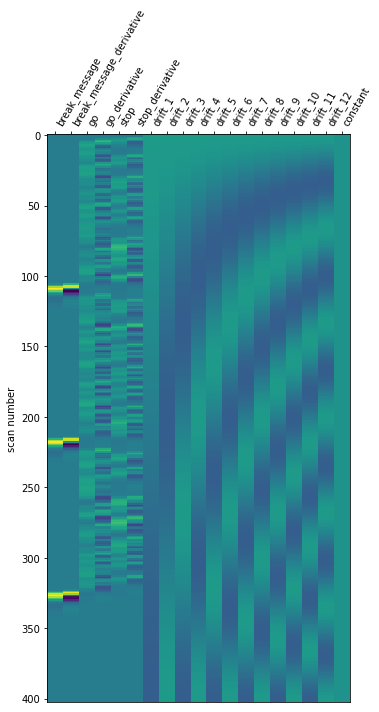

In [7]:
events = make_stop_signal_timings(nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift)

# We can grab the desmat from this function
_, _, desmat = est_eff_and_vif(events, tr, total_time, contrasts)

plot_design_matrix(desmat)
plt.show()

In [8]:
# There's probably a way to generalize this to work with all tasks,
# but the psychological assessment code requires condition to be coded by a single letter,
# but that's not convenient for the other code...so here we are...
def run_stop_signal_eff_sim(nsim, nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info):
    '''
    Runs nsim randomly created stop signal designs through efficiency/vif/psych fitness
    measures and outputs results
    Input: 
      nsim:  Number of simulated design matrices
    Output:
      output: Pandas data frame with each fitness measure for each design
      events_all:  The events data for each design matrix
    '''
    output = {
        'eff_stop-go': [],
        'eff_stop': [],
        'eff_go': [],
        'eff_task': [],
        'vif_stop-go': [],
        'vif_stop': [],
        'vif_go': [],
        'vif_task': [],
        'scan_length':[],
        'kao_measure': [],
        'prob_runs_gte_2': [],
        'run_num_diff_from_avg': [],
        'prob_next_given_last1': [],
        'prob_next_given_last2': [],
        'pred_second_half_from_first': []
    }
    all_events = []

    for sim in range(nsim):
        events = make_stop_signal_timings(nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                                isi_shift)
        if np.max(events.onset) > total_time:
            print('WARNING:  You need to increase the total time to fit all trials \n'
                'estimates from this simulation set should be discarded')
        eff_vals, vifs, _ = est_eff_and_vif(events, tr, total_time, contrasts)
        trials_no_breaks = events.trial_type[events.trial_type != 'break_message']
        # swap out stop/go for s/g (otherwise the est_psych_fitness function breaks)
        swaps = {'stop': 's', 'go': 'g'}
        trials_no_breaks = np.array(trials_no_breaks.replace(swaps))
        psych_assess = est_psych_fitness(trials_no_breaks, avg_trial_repeats_info)
        for key, val in eff_vals.items():
            output[f'eff_{key}'].append(val)
        for key, val in vifs.items():
            output[f'vif_{key}'].append(val)
        for key, val in psych_assess.items():
            output[key].append(val)
        all_events.append(events)
        output['scan_length'].append(
            events.onset.values[-1:][0] + events.duration.values[-1:][0] + 20)
    return pd.DataFrame(output), all_events

I run the simulations and make a monster plot that is nice and gets easier to understand the more you do this. For efficiency, larger is better.  For the rest of the measures smaller is better.

In [9]:
nsim = 500
output_setting1, events_setting1 = run_stop_signal_eff_sim(nsim, nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info)

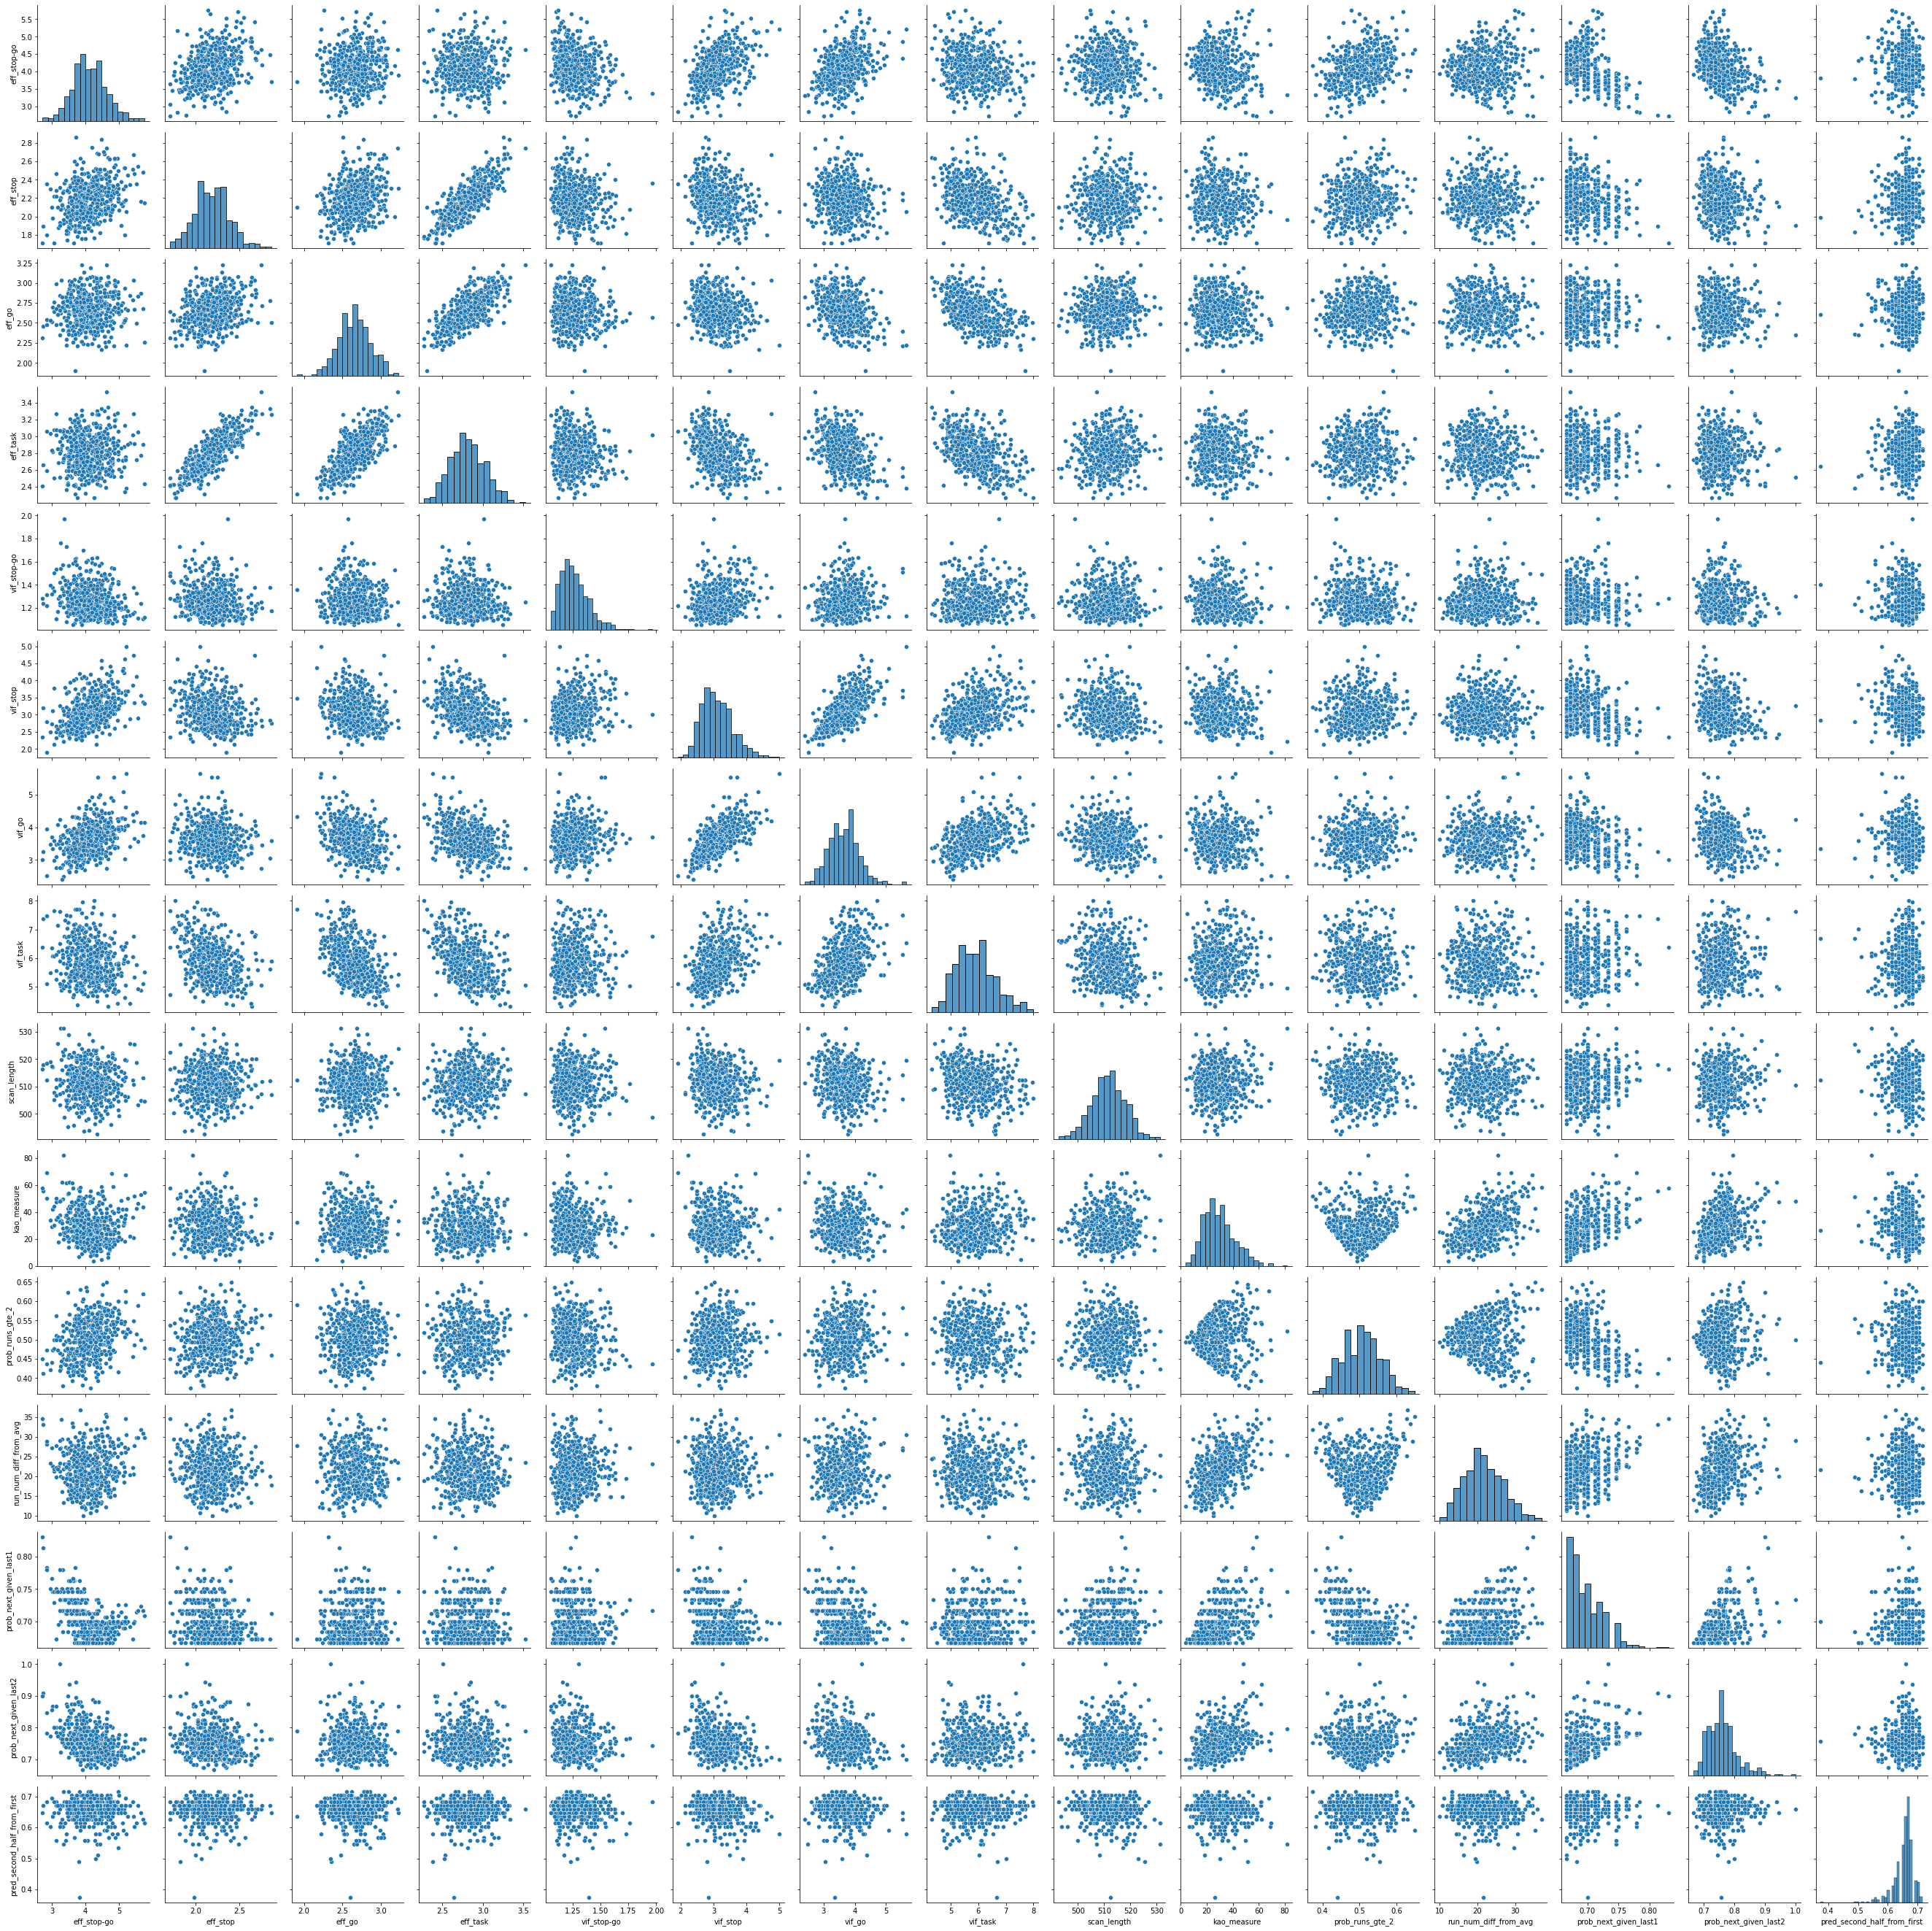

In [10]:
g = sns.PairGrid(output_setting1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Here's what I notice so far:
* First, an important learning moment that answers the question, "why don't we just use VIF instead of efficiency?".  Because VIF is only quantifying the collinearity of regressors in a model and does not capture the full impact of the design matrix on the overall within-subject variability.  Pick a small VIF for stop-go and note the efficiencies span the entire range of possible efficiencies.  An additional concern is the VIF for a contrast may not be giving us good information about the design if the VIFs are high for any of the regressor parameters involved in the contrast. So our goal it to minimize efficiency while choosing from designs with reasonable VIFs, when we can rely on the VIFs.  This plot shows we are in the realm of reasonable VIFs, which is good.
* Although the VIFs look decent, some of the VIFs are near 5 for go vs baseline and that is not great. I dig into it in the next chunk of code. The VIFs for task (average of stop and go vs baseline) are high because the sum of the stop and go regressors will be pretty close to the intercept regressor, due to the lack of baseline.
* The longest scans (max_onset_plus_duration_plus_20) are not the most efficient.  If they were, this might indicate longer ISIs are helping (since that's the only thing increasing the length of the run).  We might be able to use a shorter ISI?  Spoiler, we cannot because the VIF investigation will reveal we don't have enough baseline as it is and shortening the ISI shortens the baseline.  
* The efficiencies are approximately Normally distributed, and it isn't likely we'll want a design from the tails of these distributions since the psychological measures tend to be big (big=bad).  Running 100,000 simulations (what we'll do on Sherlock) really only gives us more options in the tails of the efficiency distribution, but we're not like to use these anyhow, since the psychological measures are often not great (recall from above: more efficient = more blocky, more blocky = not as good psychologically).
* There's more of a range of total run times than I thought there would be and some of the designs that have shorter runs have pretty good efficiency, which is good news. Again, the shorter ones may not work out great since they'll have less baseline (which drives the VIFs for go  and stop up, which we'll see shortly).
* Generally the distributions look like I'd expect them too, so I don't think there are coding errors.


Below I look into what is causing the higher VIFs for go versus baseline.  Even though VIF is a bit finicky (what we'll discover below), if we determine we can rely on it, it can verify that the range of designs we're considering aren't all poop.  Recall the efficiency analysis is only ranking designs, so if we just pick out the "best" piece of poop out of a pile of poops, we're not really setting ourselves up for success.  This code is to figure out whether our poop detector (VIF) is actually giving us good information for stop-go (as well as stop and go vs baseline).

What we'll discover is:
* Stop is driving the high VIF for go (this can be bad)
* Stop is only driving the high VIF for go because there is limited baseline (this makes it okay)
* Because of the last point, the VIF for stop-go is okay!
* We might want to study go vs baseline in the future, so we'll need to scoot that VIF down if possible (by adding more baseline)

Here I run the regression that VIF is based off of: go as a function of all of the other regressors.  The stats for the individual parameters are useful clues for what is driving VIF up!


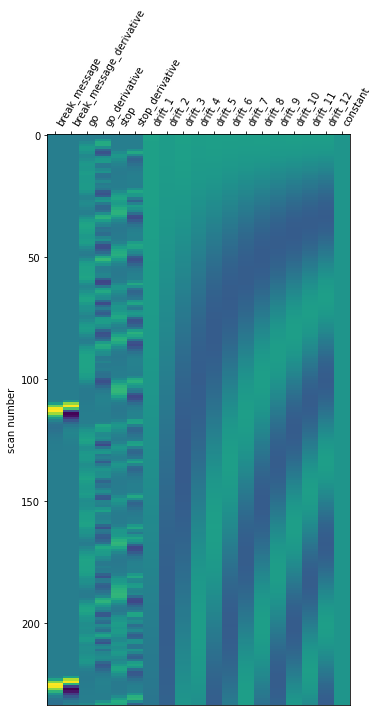

                            OLS Regression Results                            
Dep. Variable:                     go   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     59.06
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           2.46e-71
Time:                        18:16:36   Log-Likelihood:                 301.79
No. Observations:                 234   AIC:                            -567.6
Df Residuals:                     216   BIC:                            -505.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
break_message           

In [11]:
# find the index of the design with the largest VIF for go
isi_max_ind = np.argmax(output_setting1['vif_go'])

max_vif = output_setting1['vif_go'].values[isi_max_ind]
events_worst_go_vif = events_setting1[isi_max_ind]
# use this to get the design matrix
eff, vif, desmat1 = est_eff_and_vif(events_worst_go_vif, tr, total_time, contrasts)

# Note, if you look at the est_eff_and_vif code you'll see I truncate the session at the end if the
# trials stop.  I go 20s beyond the offset of the last trial, so the "fixation" at the
# end, which won't be in the real design, won't impact things.  
scan_cutoff = int(np.floor((events_worst_go_vif.onset.values[-1:][0] + 
                            events_worst_go_vif.duration.values[-1:][0] + 20))/tr)
desmat1_trimmed = desmat1.loc[:scan_cutoff, :]

plot_design_matrix(desmat1_trimmed)
plt.show()


mod = sm.OLS(desmat1_trimmed['go'], desmat1_trimmed.drop(columns=['go'])).fit()
print(mod.summary())
print(f'VIF check (should match the max VIF in the next line): {1/(1-mod.rsquared)}')
print(f'max VIF = {max_vif}')


In the above, I start with a double check that the R-squared reproduces the VIF that was calculated earlier (to be sure I grabbed the right events file). It is clear the cosine basis functions (the drift terms that model the highpass filter) are often significant as are the regressors for the break and stop.  The t-stat for stop is pretty huge, so I suspect it is the primary problem here. We can test how much the stop regressor drives the overall VIF by removing it from the above model and recalculating the VIF.  If it drops a lot, then we know stop is related to the problem.

In [12]:
mod = sm.OLS(desmat1_trimmed['go'], desmat1_trimmed.drop(columns=['go', 'stop'])).fit()
print(mod.summary())
print(f'VIF without stop: {1/(1-mod.rsquared)}')

                            OLS Regression Results                            
Dep. Variable:                     go   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     5.107
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           5.43e-09
Time:                        18:16:36   Log-Likelihood:                 136.61
No. Observations:                 234   AIC:                            -239.2
Df Residuals:                     217   BIC:                            -180.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
break_message           

The VIF has now  dropped from around 5 to around 2.  At this point it might be easy to conclude that stop is the problem *but* this is where some head scratching is needed. Let's simplify what is going on and assume each TR is turned "on" for one of our 4 possibilities: go (most of the trials), stop (the second highest number of trials), block message (only happens 3 times), baseline (there's not a ton of fixation in this task).  Observation number 1 is that go vs baseline is going to be difficult to estimate because you need a good baseline estimate (the intercept in the fMRI model) and that requires a good amount of baseline trials, which we do not have.  Observation number 2 is more directly related to the VIF, which is measuring collinearity, or how well the value of one regressor (or values of a set of regressors) informs the value of another.  In this case if we know a stop isn't happening, we have a high chance of being correct if we guess a go is happening (since fixation and block messages are rare).  If there was more fixation in the mix, the probability that our "go is happening" guess would go down.

So, the conclusion is that yes, it is the case that stop is driving the high VIF for go, but it is only because there's so little baseline.  If we include more baseline it will alleviate the VIF issues for go.  Since baseline is *not* included in the stop-go contrast, then we can trust the VIF for stop-go.

FYI, my other hint that the VIF was okay was that as I tweak the parameter settings to make the VIF for go better and much, much worse, the VIF for stop-go was stable.  That might be an easier way to test this out in the future.  If you contrast is A-B and the VIF for A and/or B is high, tweak your design to make the VIFs for A and B much better or worse and see if that impacts the A-B VIF.  If not, then the A-B VIF is okay.  Of course you can only play this game during the study design stage and *not* if you've already collected the data.  In that case you need to take the deep thoughts approach.

#### What to focus on as we move forward

Later on the best designs will be selected by balancing statistical efficiency with the psychological factors.  For our purposes here, we're just trying to get one or two reasonable looking design setups to run on Sherlock.  For the rest of the exploration here we do not need to revisit the psychological factors, but they will become very important when we're selecting from designs after the Sherlock step.

Here we will focus only on the factors that are impacted by changing the ISI, number of trials, stimulus durations, etc.  Those values are the efficiencies, VIFs and scan length (last_onset+last_duration+20).  I'll save the 5th, 50th (median) and 95th percentiles of these values from our starter design for comparison with other design settings.

In [13]:
# make a dictionary so I can add other results to it

pd.set_option('display.width', 1000)
eff_vif_summaries = {}

eff_vif_summaries['setting1']= np.round(output_setting1[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05, .5, .95]), 2)

print('95th percentile of efficiencies')
print(eff_vif_summaries['setting1'])

95th percentile of efficiencies
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61


##### Lengthen the ISI

Let's see what things look like if I only make the mean ISI longer (via the isi_exp_lam parameter).  This isn't feasible for the actual study that Team Patrick $^\copyright$ is running, but is run for illustrative purposes in the case that you're working with a study where you have more flexibility to increase the scan time.

In [14]:
isi_exp_lam_longer_isi = 1  # Was 2, so mean will now be just shy of 1.5

First take a look at the ISI distribution and a design matrix.  I already know we cannot use this design, but if we were considering it I would ask Team Patrick $^\copyright$ to give me feedback about the ISI distribution since there are now many more larger ISIs than with our last setting.

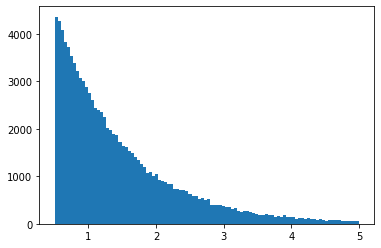

The theoretical mean is: 1.449447932838815
Quartiles: [0.5   0.786 1.184 1.845 4.998]


In [15]:
nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(isi_exp_lam_longer_isi, isi_truncation, 
                                                                 isi_shift, nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.show()
print(f'The theoretical mean is: {theoretical_mean}')
print(f'Quartiles: {isi_quartiles}')

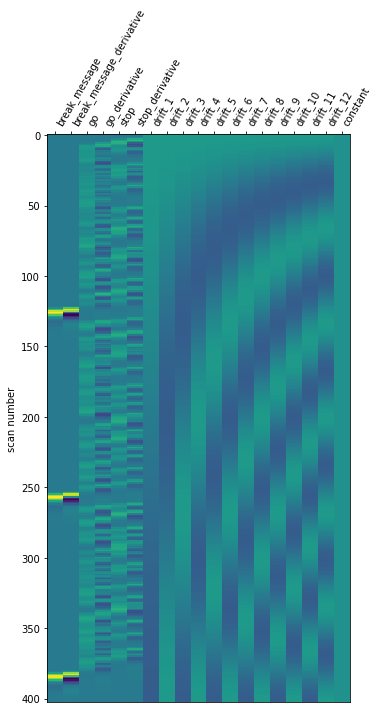

In [16]:
events_longer_isi = make_stop_signal_timings(nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam_longer_isi, isi_truncation, 
                             isi_shift)

_, _, desmat_longer_isi = est_eff_and_vif(events_longer_isi, tr, total_time, contrasts)

plot_design_matrix(desmat_longer_isi)
plt.show()

The code might be upset if the scan was too long (longer than the total_time variable).  As long as there are only 1 or 2, that's fine for our purposes here, but for the real efficiency search, you must be sure the total_time is long enough to avoid this error completely or else all of you trials will not actually be run during the scan!

In [17]:
nsim = 500
output_setting_longer_isi, events_longer_ISI = run_stop_signal_eff_sim(nsim, nstop, ngo, stop_dur, 
                                go_dur, blank_dur, nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam_longer_isi, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info)

estimates from this simulation set should be discarded
estimates from this simulation set should be discarded


Here I'm most interested in whether the efficiencies grow a lot.  For me, I'd like to see at least a 50% increase in efficiency.  The efficiencies don't really change that much, so this really isn't worth it.  You can see that the VIFs for go decrease a bit and this is because by lengthening the fixation we've added more baseline, which is really nice.  If there wasn't a severe time crunch for this task I would advocate to use this slightly longer ISI, but the scan has not increased by around 70 seconds (487 min to 560) and 9+ minute scans won't likely work out for this study.

In [18]:
eff_vif_summaries['longer ISI']= np.round(output_setting_longer_isi[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05,.5, .95]), 2)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)



Results for setting1
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61
Results for longer ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.39      1.92    2.41      2.55         1.10      1.95    2.24      3.27       571.53
0.50         4.07      2.34    2.87      3.04         1.20      2.47    2.78      3.89       593.00
0.95         4.87      2.75    3.31      3.56         1.39      3.11    3.45      4.85       611.98


#### What if lower the ISI?

Can we make the scan shorter?  In reality Team Patrick $^\copyright$ cannot do this since it won't allow enough time for the subject to respond.  For educational purposes, we'll look anyhow.  Let's decrease the mean ISI to around .75s (from 1s).  Since there are 180 trials, that could mean a time savings of 45s, which is pretty good.

In [19]:
isi_exp_lam_shorter_isi = 4  # Was 2, so mean will now be just shy of .75

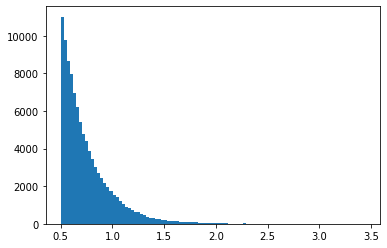

The theoretical mean is: 0.7499999314650901
Quartiles: [0.5   0.573 0.674 0.848 3.443]


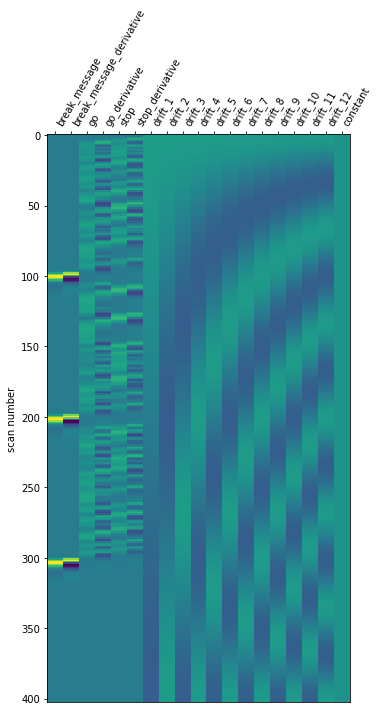

In [20]:
nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(isi_exp_lam_shorter_isi, isi_truncation, 
                                                                 isi_shift, nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.show()
print(f'The theoretical mean is: {theoretical_mean}')
print(f'Quartiles: {isi_quartiles}')

events_shorter_isi = make_stop_signal_timings(nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam_shorter_isi, isi_truncation, 
                             isi_shift)

_, _, desmat_shorter_isi = est_eff_and_vif(events_shorter_isi, tr, total_time, contrasts)

plot_design_matrix(desmat_shorter_isi)
plt.show()

In [21]:
nsim = 500
output_setting_shorter_isi, events_shorter_ISI = run_stop_signal_eff_sim(nsim, nstop, ngo, stop_dur, 
                                go_dur, blank_dur, nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam_shorter_isi, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info)

/Users/jeanettemumford/miniconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/jeanettemumford/miniconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/jeanettemumford/miniconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/jeanettemumford/miniconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


A slight bump in efficiencies, but the VIFs look worse, which was somewhat predictable.  This is a no-go from the statistical angle because of the elevated VIFs.  Keep in mind the real models will have an RT regressor and stop trial will be split up more.  It isn't clear whether these things will increase VIF further, but I imagine the RT regressor could potentially cause collinearities.

In [22]:
eff_vif_summaries['shorter ISI'] = np.round(output_setting_shorter_isi[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05, .5, .95]), 3)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61
Results for longer ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.39      1.92    2.41      2.55         1.10      1.95    2.24      3.27       571.53
0.50         4.07      2.34    2.87      3.04         1.20      2.47    2.78      3.89       593.00
0.95         4.87      2.75    3.31      3.56         1.39      3.11    3.45      4.85       611.98
Results for shorter ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05        3.213     1.860   2.

#### Decrease the pre/post message fixations

In reality Team Patrick $^\copyright$ only wanted the breaks to be 10s, but they are currently 16. As I explained in the beginning I wanted to start with more separation between the feedback signal and the task.  It may not matter and we're about to find out! 

Note, I'm switching back to the original ISI.

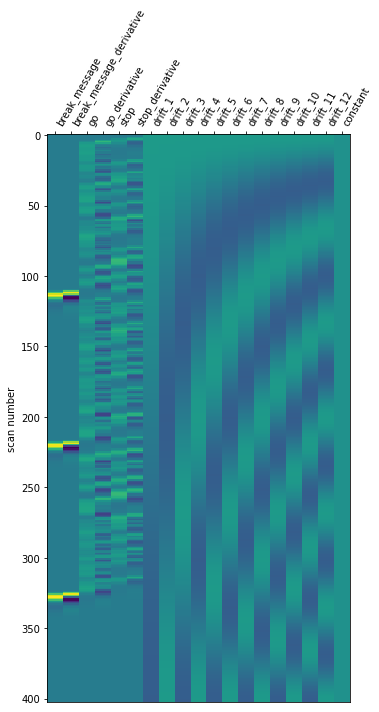

In [23]:
break_fix_pre_message_dur_shortened = 3 # this was 6s
break_fix_post_message_dur_shortened = 3 # this was 6s


events_shorter_break = make_stop_signal_timings(nstop, ngo, stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur_shortened, break_message_dur,  
                             break_fix_post_message_dur_shortened, isi_exp_lam, isi_truncation, 
                             isi_shift)

_, _, desmat_shorter_break = est_eff_and_vif(events_shorter_break, tr, total_time, contrasts)

plot_design_matrix(desmat_shorter_break)
plt.show()

In [24]:
nsim = 500
output_shorter_break, events_shorter_break = run_stop_signal_eff_sim(nsim, nstop, ngo, stop_dur, 
                                go_dur, blank_dur,  nbreaks, 
                                break_fix_pre_message_dur_shortened, break_message_dur,  
                                break_fix_post_message_dur_shortened, isi_exp_lam, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info)

In [25]:
eff_vif_summaries['shorter break'] = np.round(output_shorter_break[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05, .5, .95]), 3)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61
Results for longer ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.39      1.92    2.41      2.55         1.10      1.95    2.24      3.27       571.53
0.50         4.07      2.34    2.87      3.04         1.20      2.47    2.78      3.89       593.00
0.95         4.87      2.75    3.31      3.56         1.39      3.11    3.45      4.85       611.98
Results for shorter ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05        3.213     1.860   2.

The above isn't very promising.  As was already identified, not having much baseline is contributing to high collinearity for go driven by stop and vice-versa.  You can see the increased VIF is impacting the efficiencies for each of stop and go.  Notably, the efficiency of the stop-go contrast isn't hugely impacted compared to the setting1 designs and that is because it is the combination of the lack of baseline along with stop driving the VIF for go and baseline is not involved in the stop-go contrast.  Below I take the ratios, which shows how much the within-subject variance will increase with the shorter fixation before/after the message.  The median go is 47% higher for the less efficient design, which isn't good.  Stop is about 38% larger and stop-go isn't impacted.

I'm not super comfortable with this setting.  If we were 100% sure there would not be an interest in studying each condition vs baseline, perhaps this is okay *but* as I've mentioned we don't know how the future RT regressor will further impact things and we would be better set up if the VIFs here were smaller.



In [26]:
var_ratio = (eff_vif_summaries['setting1'][['eff_stop-go', 'eff_stop', 'eff_go']].values/
             eff_vif_summaries['shorter break'][['eff_stop-go', 'eff_stop', 'eff_go']].values)
var_ratio_df = pd.DataFrame(var_ratio, columns=['eff_stop-go', 'eff_stop', 'eff_go'], 
                            index=eff_vif_summaries['setting1'].index )
print(var_ratio_df)

      eff_stop-go  eff_stop    eff_go
0.05     0.993437  1.448382  1.513970
0.50     1.000488  1.388713  1.465565
0.95     1.005857  1.334746  1.403263


#### Pie in the sky example

If we really had 10 minutes to play with, what improvements could we see if we added more trials?  Building off of the setting1 settings, I'm just going to add more trials.  This does impact the average trial repeat counts (since the trial numbers change) so I'll need to recalculate that.  

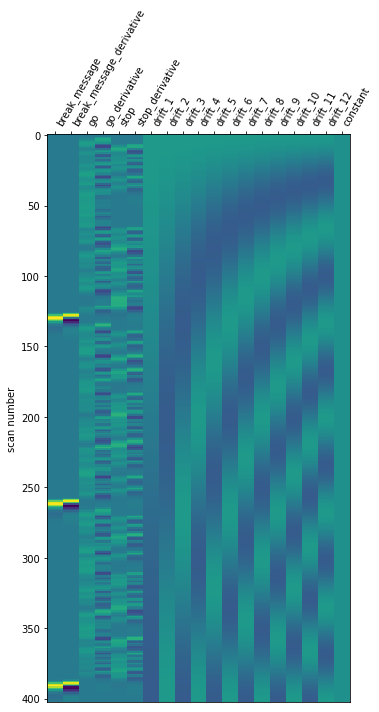

In [27]:
nstop_more_trials = 72 # was 60
ngo_more_trials = 144 # was 120


events_more_trials = make_stop_signal_timings(nstop_more_trials, ngo_more_trials, 
                            stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift)

_, _, desmat_more_trials = est_eff_and_vif(events_more_trials, tr, total_time, contrasts)

plot_design_matrix(desmat_more_trials)
plt.show()

Next, I need to update the avg_trial_repeats_info variable for this design since I've changed the number of trials.

In [28]:
unpermuted_trials_more_trials = np.concatenate([np.repeat('s', nstop_more_trials/3), 
                                    np.repeat('g', ngo_more_trials/3)],
                                    axis=0)
avg_trial_repeats_info_more_trials = calc_expected_run_num_by_chance(unpermuted_trials_more_trials, nsims=5000)
avg_trial_repeats_info_more_trials['g_run_counts'] = avg_trial_repeats_info_more_trials['g_run_counts'] * 3
avg_trial_repeats_info_more_trials['s_run_counts'] = avg_trial_repeats_info_more_trials['s_run_counts'] * 3

In [29]:
nsim = 500
output_more_trials, events_more_trials = run_stop_signal_eff_sim(nsim, nstop_more_trials, ngo_more_trials,
                                stop_dur, 
                                go_dur, blank_dur,  nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info_more_trials)

estimates from this simulation set should be discarded
estimates from this simulation set should be discarded


In [30]:
eff_vif_summaries['more trials'] = np.round(output_more_trials[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05, .5, .95]), 3)

for key, val in eff_vif_summaries.items():
    print(f'Results for {key}')
    print(val)

Results for setting1
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61
Results for longer ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.39      1.92    2.41      2.55         1.10      1.95    2.24      3.27       571.53
0.50         4.07      2.34    2.87      3.04         1.20      2.47    2.78      3.89       593.00
0.95         4.87      2.75    3.31      3.56         1.39      3.11    3.45      4.85       611.98
Results for shorter ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05        3.213     1.860   2.

Now this is a noticeable improvement.  The efficiencies are much higher than setting1 with these extra trials.  Recall we can directly estimate how the within-subject variance is impacted through the ratio eff(more trials) is 1/var(more trials), so var(more trials)/var(setting 1) is eff(setting 1)/eff(more trials).  I calculate this below and the variance in the stop-go contrast is reduced by 20%, while the stop and go contrasts are about the same.  If we really had the time, this could be worthwhile.  For group analyses the between-subject variance often dominates the overall variance, but for between-subject analyses or any analysis that might be within-subject, this variance reduction could help power a little.

If the variance reduction was 50%, I'd be more pushy about adding more time.  In this case I know that time doesn't exist though.

In [31]:
var_ratio = (eff_vif_summaries['setting1'][['eff_stop-go', 'eff_stop', 'eff_go']].values/
             eff_vif_summaries['more trials'][['eff_stop-go', 'eff_stop', 'eff_go']].values)
var_ratio_df = pd.DataFrame(var_ratio, columns=['eff_stop-go', 'eff_stop', 'eff_go'], 
                            index=eff_vif_summaries['setting1'].index )
print(var_ratio_df)

      eff_stop-go  eff_stop    eff_go
0.05     0.816176  0.994183  1.030062
0.50     0.826780  0.979428  1.024259
0.95     0.840081  0.971847  1.015520


### Compare extending ISI to extending fixation around message

The lack of fixation is what is driving the increased VIFs for go vs baseline and stop vs baseline.  I was curious whether adding fixation through an extended ISI would be more or less helpful than simply increasing the fixation around the feedback message between blocks.

For this comparison I need to equate the amount of fixation that I'm adding.  For the longer ISI setting used above, the mean fixation before stop/go trials was increased from 1 to 1.5.  Since there are 180 trials, that is a 90s increase in fixation, overall.  

It is a bit silly, but what if I instead add 90s of fixation to the fixed length fixations before/after the feedback message between blocks (and at the end).  There are a total of 6 fixations, so I'd need to extend each by 90/6 = 15s.  Since they are 6s long in the setting 1 settings, I'll be extending them to 21s.  This is completely a ridiculous design, but this answers the question about whether or not it matters *where* fixation is added.  Let's see what the numbers say...

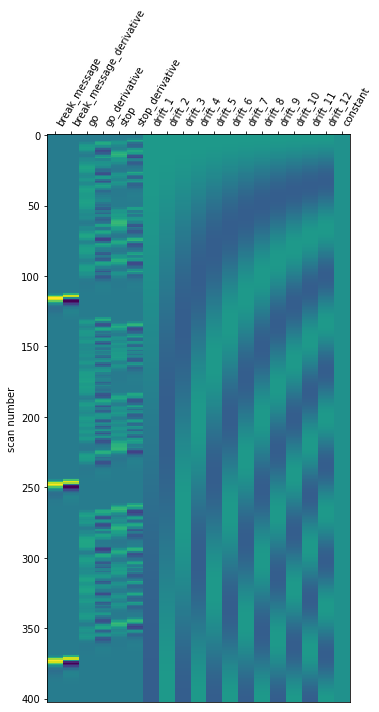

In [32]:
break_fix_pre_message_dur_extended = 6 + 15
break_fix_post_message_dur_extended = 6 + 15

# Show how bananas this design is

events_message_fix_extended = make_stop_signal_timings(nstop, ngo, 
                            stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur_extended, break_message_dur,  
                             break_fix_post_message_dur_extended, isi_exp_lam, isi_truncation, 
                             isi_shift)

_, _, desmat_message_fix_extended = est_eff_and_vif(events_message_fix_extended, tr, total_time, contrasts)

plot_design_matrix(desmat_message_fix_extended)
plt.show()



In [33]:
nsim = 500
output_message_fix_extended, events_message_fix_extended = run_stop_signal_eff_sim(nsim, nstop, ngo, stop_dur, 
                                go_dur, blank_dur, nbreaks, 
                                break_fix_pre_message_dur_extended, break_message_dur,  
                                break_fix_post_message_dur_extended, isi_exp_lam, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info)

In [34]:
eff_vif_summaries['extended fix around message'] = \
    np.round(output_message_fix_extended[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05, .5, .95]), 3)

for key, val in eff_vif_summaries.items():
    if key in ['setting1', 'longer ISI', 'extended fix around message']:
        print(f'Results for {key}')
        print(val)

Results for setting1
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61
Results for longer ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.39      1.92    2.41      2.55         1.10      1.95    2.24      3.27       571.53
0.50         4.07      2.34    2.87      3.04         1.20      2.47    2.78      3.89       593.00
0.95         4.87      2.75    3.31      3.56         1.39      3.11    3.45      4.85       611.98
Results for extended fix around message
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05        3.27

This is a bit of a mixed bag.  First, the stop-go results do not change much, since that contrast isn't impacted by the amount of baseline.  The VIF for go is worse when the fixation around the message is extended compared to when the ISI is longer.  Interestingly, the efficiency is *better* when the fixation addition is achieved through extending fixation around the message.  This efficiency difference makes sense, since the baseline signal occurs in a block and blocks are more efficient to estimate than separate trials.  This is another illustration of why looking at VIF cannot replace looking at efficiency.

So, what does this tell us?  In this case, since the VIFs for setting1 and the efficiencies are pretty good, I'm perfectly happy sticking with that setup.  It meets our time goal fairly well and I imagine when I run 100,000 design generations I'll have some nice choices in that pool of designs.



#### What if we decrease the number of trials and increase the ISI?

So far I'm leaning toward setting1 but Russ wondered if we could lower the VIFs a bit while retaining some efficiency if we reduced the number of trials and increased the ISI.  

For every stop trial there are 2 go trials.  If I were to remove 18 trials total (6 stop and 12 go), that's 18*2.5=45 additional seconds, total.  

There would then be 162 trials, so that would mean I could add 45/162 = .28s to each ISI.  I'm not sure that will help, but let's see how much efficiency is impacted by the trial loss.  

To make things easier, I'm just going to extend the break (both the break and fixation contribute to baseline, so it doesn't matter too much where I add it, statistically speaking).



In [35]:
nstop_fewer_trials_longer_base = 54 # was 60
ngo_fewer_trials_longer_base = 108 # was 120
blank_dur_fewer_trials_longer_base = .78 #was .5


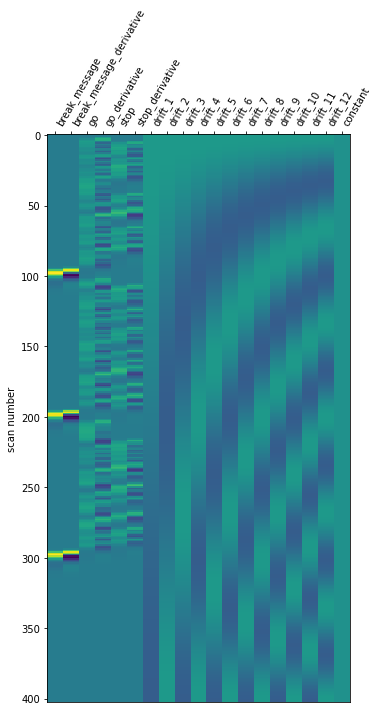

In [36]:
events_fewer_trials_longer_base = make_stop_signal_timings(nstop_fewer_trials_longer_base, 
                            ngo_fewer_trials_longer_base, 
                            stop_dur, go_dur, blank_dur, nbreaks, 
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift)

_, _, desmat_fewer_trials_longer_base = est_eff_and_vif(events_fewer_trials_longer_base, 
                                                        tr, total_time, contrasts)

plot_design_matrix(desmat_fewer_trials_longer_base)
plt.show()

In [37]:
nsim = 500
output_fewer_trials_longer_base, events_fewer_trials_longer_base = run_stop_signal_eff_sim(nsim, nstop_fewer_trials_longer_base,
                                ngo_fewer_trials_longer_base, stop_dur, 
                                go_dur, blank_dur_fewer_trials_longer_base, nbreaks, 
                                break_fix_pre_message_dur, break_message_dur,  
                                break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                                isi_shift, total_time, contrasts, avg_trial_repeats_info)

In [38]:
eff_vif_summaries['fewer trials w more baseline'] = \
    np.round(output_fewer_trials_longer_base[['eff_stop-go', 'eff_stop', 'eff_go', 
                                              'eff_task','vif_stop-go', 'vif_stop', 'vif_go', 
                                              'vif_task','scan_length']].quantile(q=[.05, .5, .95]), 3)

for key, val in eff_vif_summaries.items():
#    if key in ['setting1', 'longer ISI', 'fewer trials w more baseline']:
        print(f'Results for {key}')
        print(val)

Results for setting1
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.33      1.88    2.33      2.47         1.10      2.47    2.87      4.85       500.79
0.50         4.10      2.19    2.66      2.81         1.25      3.05    3.65      5.81       511.63
0.95         4.98      2.52    3.01      3.17         1.52      3.97    4.43      7.17       521.61
Results for longer ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05         3.39      1.92    2.41      2.55         1.10      1.95    2.24      3.27       571.53
0.50         4.07      2.34    2.87      3.04         1.20      2.47    2.78      3.89       593.00
0.95         4.87      2.75    3.31      3.56         1.39      3.11    3.45      4.85       611.98
Results for shorter ISI
      eff_stop-go  eff_stop  eff_go  eff_task  vif_stop-go  vif_stop  vif_go  vif_task  scan_length
0.05        3.213     1.860   2.

This turned out to be the worst of both worlds.  Even though we added a little more baseline, it didn't do much for the VIF, meanwhile the efficiencies have dipped because there are fewer trials.  In this case it isn't a worthwile endeavor to decrease the trials even more in an effort to decrease the VIF.  We'd lose too much efficiency.

Luckily the signal for task vs baseline is usually pretty large, so it will likely overcome any increased variability issues due to a slightly elevated VIF.  The constrast of interest, stop-go, has a much smaller effect size, so it is harder to power and low efficiency is much more important for it.

### Step 5: Make a choice and run many simulations on Sherlock



Basically I took the code from above using the "setting1" settings and ran 100000 design generations on sherlock.  I broke it into 5 jobs, so it didn't take that long (maybe an hour?).  That's why there are 5 sets of files.

In [39]:
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/design_and_analysis/code_in_progress/output'

In [40]:
events_all = []
for i in range(1,6):
    with open(f'{outdir}/events_{i}.pkl', "rb") as f: 
        events = pickle.load(f)
    events_all.extend(events)


In [41]:
output_list = []

for i in range(1,6):
    output_list.append(pd.read_csv(f'{outdir}/output_{i}.csv'))



In [42]:
output_all = pd.concat(output_list, ignore_index=True)

In [43]:
# Get the ranks for each column 

ranks = {col: np.argsort(output_all[col].to_numpy()) for col in output_all.columns}

In [44]:
# Reality check.  The first rank is the minimum and the values increase with rank
print(output_all['eff_stop-go'][ranks['eff_stop-go'][0]])
print(output_all['eff_stop-go'][ranks['eff_stop-go'][1]])
print(output_all['eff_stop-go'][ranks['eff_stop-go'][2]])
print(output_all['eff_stop-go'][ranks['eff_stop-go'][3]])
print('this is the min')
print(output_all['eff_stop-go'].min())

print('is this the max?')
print(output_all['eff_stop-go'][30587])
print(output_all['eff_stop-go'][ranks['eff_stop-go'][-1]])
print(output_all['eff_stop-go'].max())




2.265399872432158
2.2711095335453537
2.29379526924918
2.4131211323996027
this is the min
2.265399872432158
is this the max?
6.737797019341515
6.737797019341515
6.737797019341515


In the following, recall that the best efficiency is high while every other measure is best when low.

In [45]:

best_high = ['eff_stop-go', 'eff_stop', 'eff_go', 'eff_task']
#best_low = ['vif_stop-go', 'vif_stop', 'vif_go', 'vif_task', 'scan_length', 'kao_measure',
#            'prob_runs_gte_2', 'run_num_diff_from_avg',
#            'prob_next_given_last1', 'prob_next_given_last2', 
#            'pred_second_half_from_first']

best_low = ['vif_stop-go', 'vif_stop', 'vif_go', 'vif_task', 'kao_measure',
            'prob_runs_gte_2', 'run_num_diff_from_avg',
            'prob_next_given_last1', 'prob_next_given_last2', 
            'pred_second_half_from_first']


# A while loop takes too long.  I just kept picking top numbers until I got
# around 10 top models
#top_number = 39150

top_number = 37000

overlap_set = set(np.arange(output_all.shape[0]))
for high_label in best_high:
    overlap_set = set.intersection(overlap_set, ranks[high_label][-top_number:])
for low_label in best_low:
    overlap_set = set.intersection(overlap_set, ranks[low_label][:top_number])
len_overlap_set = len(overlap_set)

print(overlap_set)
overlap_array = np.array(list(overlap_set))
print(len(overlap_array))


{37920, 97442, 59715, 11945, 6059, 7790, 98743, 90939, 21916}
9


In [46]:
def draw_histograms(output, overlap_array, variables, n_rows, n_cols):
    '''
    Plots histogram and location of top model picks
    '''
    line_colors = sns.color_palette("bright", len(overlap_array))
    fig=plt.figure(figsize=(12, 12))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.hist(output[var_name], 100, color='lightgray')
        if 'vif' in var_name:
            ax.axvline(x=5, color='black', 
                    linewidth=2)
        for color_ind, index in enumerate(overlap_array):
            ax.axvline(x=output_all[var_name][index], color=line_colors[color_ind], 
                    linewidth=1, label=index)
        ax.set_title(var_name)
        ax.legend(fontsize=7)
    fig.tight_layout()  
    plt.show()

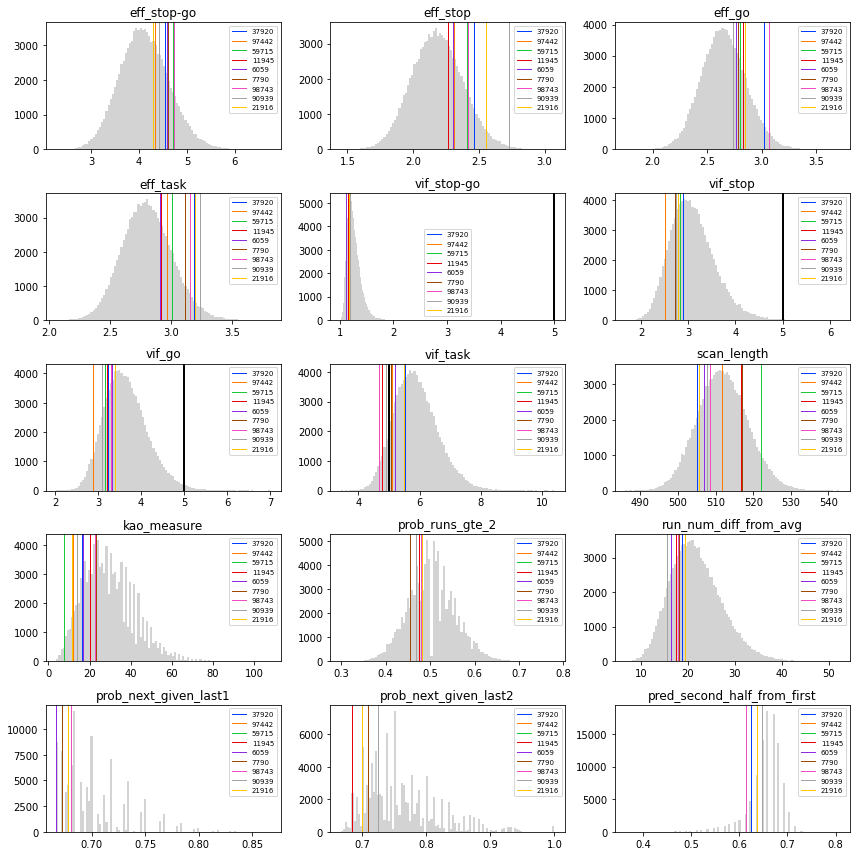

[37920 97442 59715 11945  6059  7790 98743 90939 21916]


In [47]:
# The numbers in the legend refer to the row number of output_all and element number of events_all
all_labels = ['eff_stop-go', 'eff_stop', 'eff_go', 'eff_task',
              'vif_stop-go', 'vif_stop', 'vif_go', 'vif_task', 'scan_length', 'kao_measure',
            'prob_runs_gte_2', 'run_num_diff_from_avg',
            'prob_next_given_last1', 'prob_next_given_last2', 
            'pred_second_half_from_first']
draw_histograms(output_all, overlap_array, all_labels, 5, 3)
print(overlap_array)


Perhaps you noticed that I dropped scan_length from the limiting values (the rank for this variable wasn't considered).  It was too limiting in this case since there will be some difficulty finding a design where task vs baseline has a reasonable VIF (<5).  

Basically, choose some designs balancing the different measures that you like.  I'm pretty satisfied with all of the chosen psych measures, so I don't need to focus on that much.  Obviously we cannot see all of the lines, so some extra plotting might be necessary.  Below I chose the 3 I liked best and regenerated the plots for those 3 designs to be sure I like where they fall and to double check that I'm pulling out the values correctly (we will double check this and this is the first check).

I'm most focused on the efficiency for stop-go and then the VIF for task.  Stop-go has the least signal, so that efficiency is *very* important.  Task vs baseline has a huge amount of signal, so it can overcome some variability issues and still have high power.  That said, I'd like the VIF to be below 5, if possible.




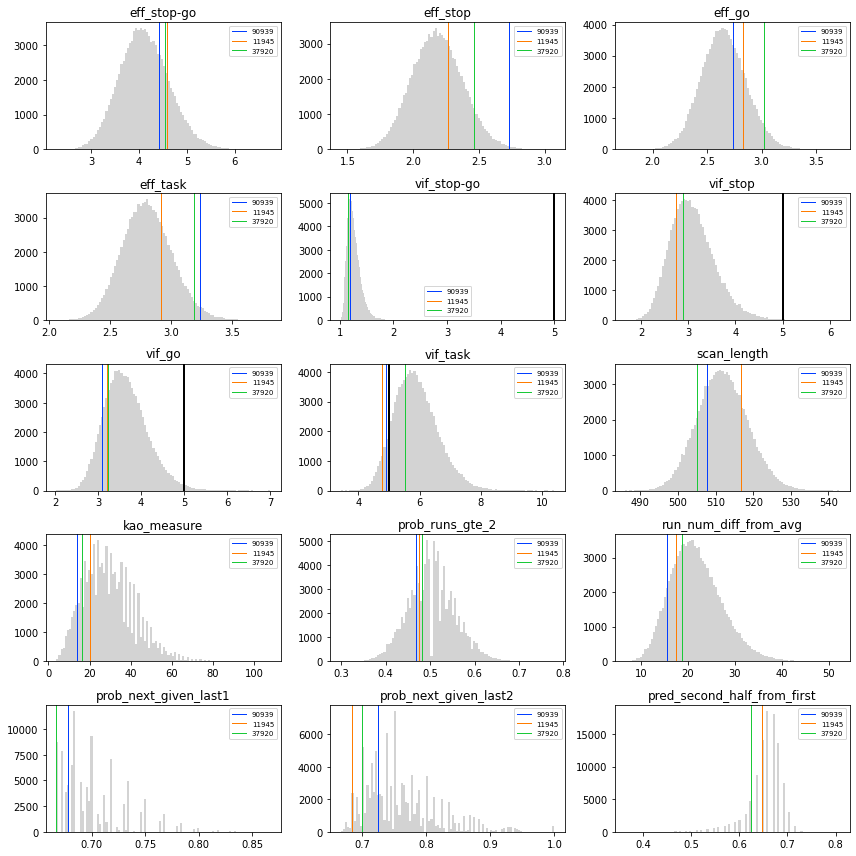

       Unnamed: 0  eff_stop-go  eff_stop    eff_go  eff_task  vif_stop-go  vif_stop    vif_go  vif_task  scan_length  kao_measure  prob_runs_gte_2  run_num_diff_from_avg  prob_next_given_last1  prob_next_given_last2  pred_second_half_from_first
90939       10939     4.425989  2.731901  2.742490  3.237773     1.187614  2.735568  3.083438  4.906039   507.634424    13.777778         0.469136                15.5100               0.677966               0.725000                     0.647727
11945       11945     4.577474  2.265491  2.830477  2.917697     1.163027  2.746867  3.206070  4.762851   516.837240    20.000000         0.475000                17.5106               0.666667               0.683544                     0.647727
37920       17920     4.542656  2.460482  3.024269  3.189715     1.161839  2.895758  3.230214  5.534173   505.019267    16.444444         0.481013                18.7702               0.666667               0.700000                     0.625000


In [48]:
# Double check where chosen_inds land (colors will change compared to above plot)
chosen_inds = [90939, 11945, 37920]
draw_histograms(output_all, chosen_inds, all_labels, 5, 3)
print(output_all.loc[chosen_inds])

Last, select the events files and save them!  Of course I'll run a second check here.

design: 90939
efficiency
{'stop': 2.731901059852845, 'go': 2.742490052977647, 'stop-go': 4.425989082427113, 'task': 3.2377731471661626}
vif
{'stop': 2.7355683214257436, 'go': 3.083438393400053, 'stop-go': 1.187613941060361, 'task': 4.906039078882694}


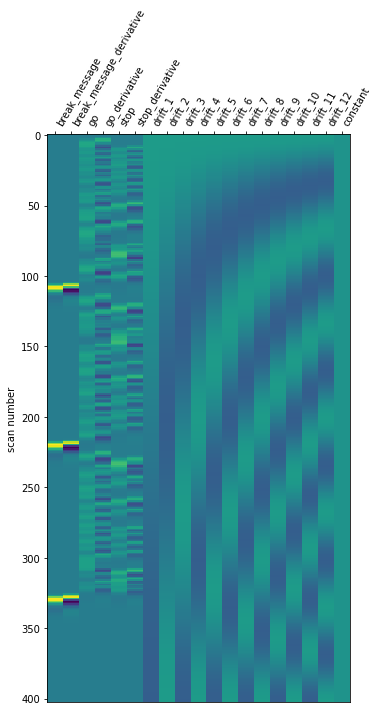

design: 11945
efficiency
{'stop': 2.265491342437754, 'go': 2.8304770167829902, 'stop-go': 4.577474409323777, 'task': 2.9176969459874766}
vif
{'stop': 2.746866573037963, 'go': 3.2060702471371743, 'stop-go': 1.1630266144118655, 'task': 4.762850869740753}


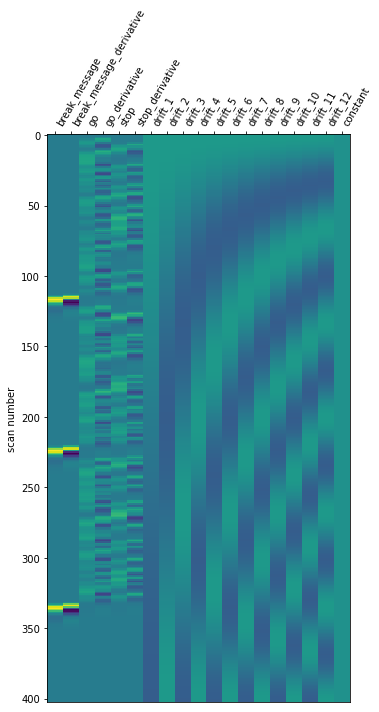

design: 37920
efficiency
{'stop': 2.460481527528163, 'go': 3.0242686909817738, 'stop-go': 4.542656429373873, 'task': 3.1897153118295183}
vif
{'stop': 2.8957584892096175, 'go': 3.230214351764021, 'stop-go': 1.1618392004517117, 'task': 5.534172874854232}


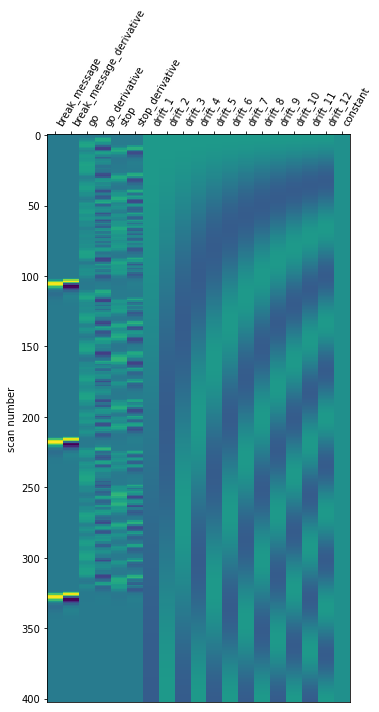

In [49]:
final_designs = []

for des_ind in chosen_inds:
    events_loop = events_all[des_ind]
    eff_loop, vif_loop, desmat_loop = est_eff_and_vif(events_loop, tr, total_time, contrasts)
    print(f'design: {des_ind}')
    print('efficiency')
    print(eff_loop)
    print('vif')
    print(vif_loop)
    plot_design_matrix(desmat_loop)
    plt.show()
    final_designs.append(events_loop)
    
    
    


Last step would is make a loop that saves out the final events files. 

In [50]:
for i in range(len(final_designs)):
    des_loop = final_designs[i]
    des_loop.to_csv(f'{outdir}/winning_design_{i}.csv')